Before Sampling: made_purchase
0    0.931898
1    0.068102
Name: proportion, dtype: float64
After Sampling: made_purchase
0    0.931898
1    0.068102
Name: proportion, dtype: float64
Fitting 3 folds for each of 4 candidates, totalling 12 fits

 Best Parameters: {'n_estimators': 100, 'min_samples_split': 10, 'max_depth': 15}

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97   1536593
           1       0.57      0.95      0.71    112292

    accuracy                           0.95   1648885
   macro avg       0.78      0.95      0.84   1648885
weighted avg       0.97      0.95      0.95   1648885


Confusion Matrix:
[[1456426   80167]
 [   5623  106669]]

Accuracy: 0.9479709015486223


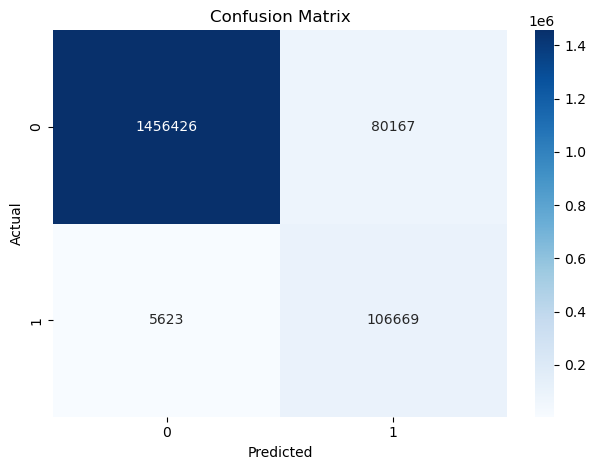


 Top Feature Importances:
num_events               0.318216
session_duration         0.219626
num_carts                0.172130
num_views                0.163935
num_unique_products      0.073399
num_brands               0.026395
max_price                0.008203
avg_price                0.004765
hour_of_day              0.004682
min_price                0.004477
num_unique_categories    0.004171
num_remove_from_cart     0.000000
dtype: float64


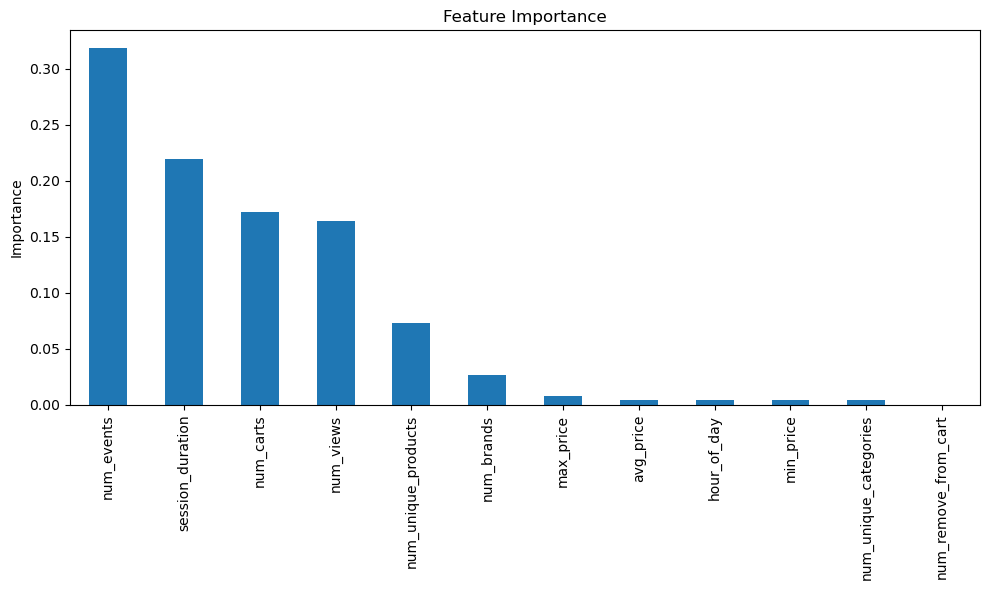


Model and scaler saved successfully for future use!


In [7]:
# Phase 3: Machine Learning Modeling for Purchase Prediction
# Goal: Predict whether a user session will lead to a purchase (made_purchase = 1 or 0)

# ---------------------------
# Step 1: Load and prepare data
# ---------------------------
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV 
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# Load the session-level dataset from Phase 2
session_df = pd.read_csv(r"D:\Sparkathon\Data\phase2_session_features.csv")
print("Before Sampling:", session_df['made_purchase'].value_counts(normalize=True))
sample_size = 10_00_000

# Ensure at least sample_size rows are available
if sample_size < len(session_df):
    _, session_df_sampled = train_test_split(
        session_df,
        train_size=sample_size,
        stratify=session_df['made_purchase'],
        random_state=42
    )
else:
    session_df_sampled = session_df  # use full data if sample size is too big

# From now on, use this for modeling
session_df = session_df_sampled

print("After Sampling:", session_df_sampled['made_purchase'].value_counts(normalize=True))

# ---------------------------
# Step 2: Define features and target
# ---------------------------

# Drop columns that won’t be used as features (identifiers or datetime)
X = session_df.drop(columns=[
    'user_session', 
    'user_id', 
    'session_start', 
    'session_end', 
    'made_purchase'
])

y = session_df['made_purchase']  # Target variable

# ---------------------------
# Step 3: Train-test split
# ---------------------------

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# ---------------------------
# Step 4: Feature scaling (important for some models)
# ---------------------------

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ---------------------------
# Step 5: Cross-validation and hyperparameter tuning
# ---------------------------

# Grid Search for best Random Forest parameters
param_dist = {
    'n_estimators': [50, 100],
    'max_depth': [10, 15],
    'min_samples_split': [5, 10]
}

grid_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(class_weight='balanced', random_state=42),
    param_distributions=param_dist,
    n_iter=4,            # ✅ Only 4 random combos tried
    cv=3,
    scoring='f1',
    verbose=1,
    n_jobs=-1
)
grid_search.fit(X_train_scaled, y_train)

best_model = grid_search.best_estimator_
print("\n Best Parameters:", grid_search.best_params_)


# ---------------------------
# Step 6: Evaluate model (Default Threshold = 0.5)
# ---------------------------

# Predict directly
y_pred = best_model.predict(X_test_scaled)

# Print evaluation metrics
report = classification_report(y_test, y_pred)
print("\nClassification Report:")
print(report)

# Save report to file
with open("classification_report.txt", "w") as f:
    f.write("Classification Report :\n")
    f.write(report)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nAccuracy:", accuracy_score(y_test, y_pred))

# Plot confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig("confusion_matrix.png")
plt.show()

# ---------------------------
# Step 7: Feature Importance
# ---------------------------

feature_importances = pd.Series(best_model.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\n Top Feature Importances:")
print(feature_importances)

# Plot feature importance
plt.figure(figsize=(10, 6))
feature_importances.plot(kind='bar')
plt.title("Feature Importance")
plt.ylabel("Importance")
plt.tight_layout()
plt.savefig("feature_importance.png")
plt.show()

# ---------------------------
# Phase 3 Done: You now have a trained and tuned model!
# ---------------------------

# 📦 Bonus: Save model and scaler for deployment/reporting
import joblib
joblib.dump(best_model, "purchase_model.pkl")
joblib.dump(scaler, "scaler.pkl")

print("\nModel and scaler saved successfully for future use!")

In [7]:
import pandas as pd

# Define 10 synthetic rows based on your testing
data = [
    [25, 10, 5, 1, 3, 2, 2000, 3000, 1500, 2, 600, 10],
    [5, 3, 0, 0, 1, 1, 500, 500, 500, 1, 120, 22],
    [50, 20, 10, 2, 5, 3, 1000, 1200, 800, 3, 900, 15],
    [8, 5, 0, 0, 2, 2, 100, 150, 50, 2, 300, 9],
    [15, 6, 2, 1, 4, 3, 2500, 4000, 1800, 4, 700, 14],
    [12, 4, 1, 0, 3, 2, 850, 950, 750, 2, 500, 18],
    [35, 18, 9, 1, 4, 3, 1800, 2500, 1200, 3, 800, 13],
    [4, 2, 0, 0, 1, 1, 300, 350, 250, 1, 100, 23],
    [20, 9, 4, 2, 3, 2, 1500, 1700, 1300, 2, 650, 11],
    [10, 6, 1, 0, 2, 2, 700, 800, 600, 2, 400, 16]
]

columns = [
    'num_events', 'num_views', 'num_carts', 'num_remove_from_cart',
    'num_unique_products', 'num_unique_categories',
    'avg_price', 'max_price', 'min_price',
    'num_brands', 'session_duration', 'hour_of_day'
]

df = pd.DataFrame(data, columns=columns)
excel_path = r"D:\Sparkathon\Data\synthetic_input.xlsx"
df.to_excel(excel_path, index=False)
print("Excel saved to:", excel_path)


Excel saved to: D:\Sparkathon\Data\synthetic_input.xlsx


In [9]:
import pandas as pd
import joblib

# === Load model and scaler ===
model = joblib.load("purchase_model.pkl")
scaler = joblib.load("scaler.pkl")

# === Load the synthetic data from Excel ===
input_path = r"D:\Sparkathon\Data\synthetic_input.xlsx"
synthetic_data = pd.read_excel(input_path)

# === Scale the features ===
scaled_data = scaler.transform(synthetic_data)

# === Predict class and probabilities ===
predicted_classes = model.predict(scaled_data)
purchase_prob = model.predict_proba(scaled_data)[:, 1]

# === Combine results with input ===
results = synthetic_data.copy()
results["Predicted_Class"] = predicted_classes
results["Purchase_Probability"] = purchase_prob.round(4)

# === Save results to CSV ===
output_path = r"D:\Sparkathon\Data\synthetic_predictions_output.csv"
results.to_csv(output_path, index=False)
print("Results saved to:", output_path)

# Optional: Show preview
print("\nPrediction Results:\n")
print(results[["Predicted_Class", "Purchase_Probability"]])


Results saved to: D:\Sparkathon\Data\synthetic_predictions_output.csv

Prediction Results:

   Predicted_Class  Purchase_Probability
0                1                0.8502
1                1                0.9325
2                1                0.9339
3                1                0.8518
4                1                0.7318
5                1                0.9567
6                1                0.8557
7                1                0.9843
8                1                0.9576
9                1                0.9554
